# Motivation


 1. Get people to know, enjoy and use ```bokeh```

  - Does not seem to be popular in HEP. However:
      - LHCb uses it for [data quality monitoring](https://cds.cern.ch/record/2298467)
      - It was [mentioned](https://arxiv.org/abs/1811.10309) by the [HEP Software Foundation](https://hepsoftwarefoundation.org/) (but dismissed)

  - It is popular and known in other areas, Astrophysics being an example

 - As other plotting alternatives, it is shadowed by the ubiquitousness of ```matplotlib``` 

 2. I personally think ```bokeh``` works better than ```matplotlib``` for the vast majority of interactive and non-interactive plots imaginable. 

```matplotlib``` is still more popular because:
 - it is much older and mature (started in 2003)

   - all default examples on StackOverflow use ```matplotlib```

   - people have the tendency to resist change

## Disclaimers

- This tutorial is heavily opinionated: the "best" plotting library can be different for different people (but ```bokeh``` is the best for me, and I will try to justify it)
- I am not an expert on any of the libraries I am going to mention: fell free to correct me if it is needed

# Why even thinking about data visualization?

# Common issues

### Matplotlib unfriendliness

- multiple APIs for the same things
- unreliable documentation
- ```kwargs```

###

# Basic plotting

### We will be comparing:

- [matplotlib](https://matplotlib.org/stable/index.html)
- [plotnine](https://plotnine.readthedocs.io/en/stable/index.html)
- [altair](https://altair-viz.github.io/)
- [bokeh](https://bokeh.org/)

#### when performing arguably two of the most common plots:

- line plot
- histogram

We start by defining everything that will be common to all libraries:

In [1]:
import numpy as np
from types import SimpleNamespace

#data for line plots
dline = SimpleNamespace( x=[1,2,3,4,5,6,7,8,9], 
                         y=[6,7,2,8,9,3,4,5,1],
                         size=15,
                         line_color='blue',
                         out_color='red', 
                         fill_color='orange',
                         fill_alpha=1 )

#data for histograms
mu, sigma, npoints = 0, 0.5, 1000
nbins = 35
dhist = np.random.normal(mu, sigma, npoints)
hist_, edges_ = np.histogram(dhist, density=False, bins=nbins)
dhist = SimpleNamespace( data=dhist, hist=hist_, edges=edges_, nbins=nbins)

## ```matplotlib```

- popular
- mature (started in 2003)
- provides a MATLAB-like interface (which can be quite unpythonic)

In [2]:
import matplotlib.pyplot as plt

#### Line plot:

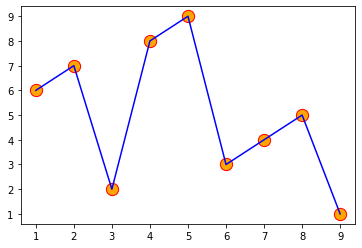

In [3]:
plt.plot(dline.x, dline.y, color=dline.line_color)

plt_marker_options = dict(s=10*dline.size, color=dline.fill_color, marker='o',
                          edgecolor=dline.out_color,
                          alpha=dline.fill_alpha)
plt.scatter(dline.x, dline.y, **plt_marker_options)
plt.show()

#### Histogram ([multiple APIs](https://matplotlib.org/stable/api/index.html)):

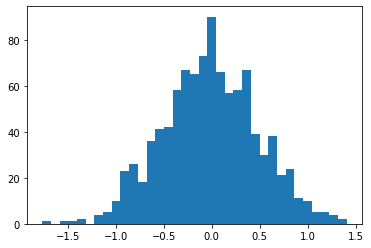

In [4]:
plt.hist(dhist.data, bins=dhist.nbins)
plt.show()

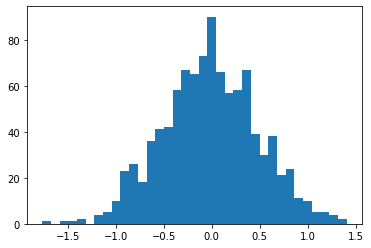

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(dhist.data, bins=dhist.nbins)
plt.show()
#we can create Figure and Axes instances explicitly

## Remarks

- ```fig``` vs ```ax``` is a constant source of confusion

- ```set_*``` methods are everywhere, where Python's ```property``` could be used instead

- It becomes quite complex to build a reasonably flexible subplotting interface (this is very easy with ```bokeh```, we will get there)

- Note that the functions we are calling are not based on what we are plotting, but instead on the actions we are performing (```plot``` and ```scatter``` instead of ```line``` and ```circles```):
   - less flexible/modular in the long-run
   - more complex to control and understand individual properties

- According to the [official documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html), the preferred way to create a single figure is to call ```subplots()```!

## Conclusions

- I find ```mtplotlib``` very hard to use without constantly going back to the documentation, even for simple tasks.
- I know many Python enthusiasts share this opinion.
- However, ```matplotlib``` is likely the library with more versatility, being the oldest. In addition, some wrappers on top of it provide additional functionalities, such as ```mplhep```.

## ```bokeh```

In [6]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook() # alternatively one could use output_file()

Loading BokehJS ...

#### Line plot:

In [7]:
# create a new plot with default tools, using figure
pline = figure(plot_width=400, plot_height=400)

marker_options = dict(size=dline.size, color=dline.out_color, 
                      fill_color=dline.fill_color, fill_alpha=dline.fill_alpha)
circ = pline.circle(dline.x, dline.y, **marker_options)
line_options = dict(line_width=2)
pline.line(dline.x, dline.y, **line_options)

show(pline)

#### Histogram:

In [8]:
hist_options = dict(fill_color="yellow", line_color="black", alpha=.8)

phist = figure(title='Bokeh Histogram', plot_width=600, plot_height=400,
                background_fill_color="#2a4f32")
phist.quad(top=dhist.hist, bottom=0, left=dhist.edges[:-1], right=dhist.edges[1:], **hist_options)
phist.ygrid.grid_line_color = None

show(phist)

## ```altair```

- Build on top of [Vega-Lite](https://vega.github.io/vega-lite/) which is based on the "grammar of graphics" (used in R's ```ggplot2```):

The grammar of graphics creates plots based on the following layers:
- Data
- Mapping
- Statistical transformation
- Geometric object (markers)
- Position adjustment
- Some additional properties

```bokeh``` also relies on a different "layered" approach:
- Mostly ignores data transformations
    - lots of excellent libraries can already take care of it
    - some exceptions: [transforming](https://docs.bokeh.org/en/latest/docs/user_guide/data.html#transforming-data), [filtering](https://docs.bokeh.org/en/latest/docs/user_guide/data.html#filtering-data)
    - as [highlighted](https://arxiv.org/pdf/1811.10309.pdf) (Sec. 2.2.3) by the HEP Soft. Found.: "**separating data visualization from the data analysis**" is a big open-issue in HEP
- Markers are applied in layers as well
- Properties are directly associated to their related objects: figures, grid, axis, markers, ...

In [9]:
import altair as alt

import pandas as pd #altair data model is build around pandas

#### Line plot:

In [10]:
alt_source_line = pd.DataFrame({'x': dline.x, 'y': dline.y})

alt_line = alt.Chart(alt_source_line).mark_line().encode(x='x', y='y')

alt_marker_options = dict(color=dline.out_color, size=10*dline.size, fill=dline.fill_color, opacity=dline.fill_alpha)
alt_markers = alt.Chart(alt_source_line).mark_point(**alt_marker_options).encode(x='x', y='y')
                          
alt.layer(alt_line, alt_markers)

alt.LayerChart(...)

#### Histogram:

1. Use ```altair``` histogram utilities
 - the syntax is more complex

2. Decouple data transformations from plotting
 - use data processed by ```numpy```
 - ```bokeh``` mostly follows this "decoupling" approach
 


In [11]:
alt_src1 = pd.DataFrame({'data': dhist.data})
alt1 = alt.Chart(alt_src1).mark_bar().encode(
    alt.X('data:Q', bin=alt.Bin(extent=[-2,2],
                                maxbins=dhist.nbins)),
    y='count()',
)
alt1

alt.Chart(...)

In [12]:
alt_src2= pd.DataFrame({'hist':dhist.hist, 
                       'edges':dhist.edges[1:]})
alt2 = alt.Chart(alt_src2).mark_bar().encode(
    y='hist',
    x='edges',
)
alt2

alt.Chart(...)

Comparison with ```bokeh```:
 - the syntax is much less readable and intuitive
 - harder to customise
 - ```bokeh``` does not require ```pandas```
 - out-of-the box interaction (not explored in this talk, see [this](https://altair-viz.github.io/altair-tutorial/notebooks/06-Selections.html) for a nice example) is way more succint, at the cost of flexibility
- <span style="color:brown">efficiency/flexibility tradeoff</span>, where (in my opinion) ```bokeh``` comes out on top

From the "Zen of Python" (```import this```):

```
Flat is better than nested.
Readability counts.
Special cases aren't special enough to break the rules.
```

## ```plotnine```

- Also follows "the grammar of graphics"
- Contrary to ```altair```, this is basically a port of ```ggplot2``` to Python

#### Line plot:

In [13]:
import plotnine as p9

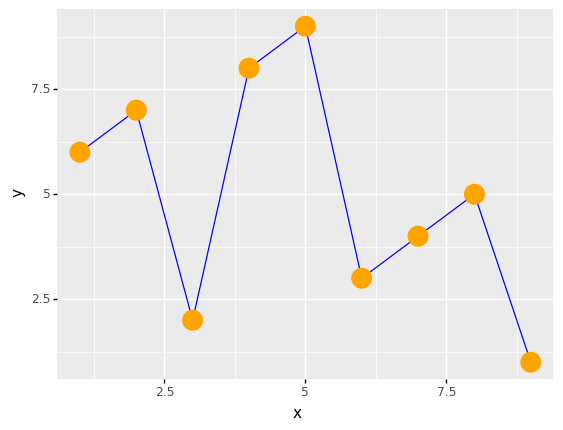

<ggplot: (8751129572849)>

In [14]:
#pandas is again required
p9_source_line = pd.DataFrame({'x': dline.x, 'y': dline.y})

(
    p9.ggplot(p9_source_line, p9.aes(x='x', y='y'))
    + p9.geom_line(color=dline.line_color) # line plot
    + p9.geom_point(color=dline.fill_color, size=0.5*dline.size) # markers
)

There seems to be no easy way to control the color of the borders!

#### Histogram:

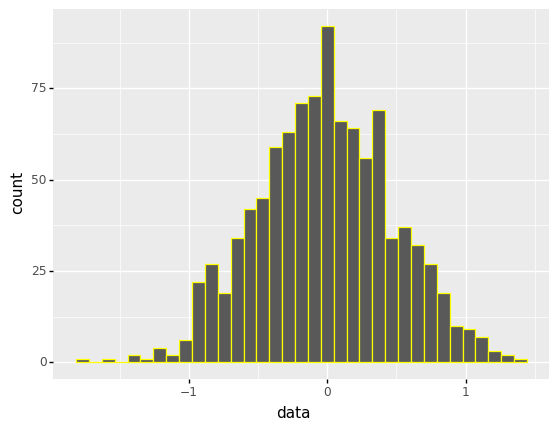

<ggplot: (8751121042333)>

In [15]:
p9_src1 = pd.DataFrame({'data': dhist.data})
(
    p9.ggplot(p9_src1, p9.aes(x='data'))
    + p9.geom_histogram(bins=dhist.nbins, color='yellow')
)

Setting the aesthetics seems much harder than it should for a beginner.

## ```bokeh```: setting properties

Figure and object properties can be very easily customised:

In [16]:
#set figure properties
pline.title = 'Line Plot'
pline.xgrid.grid_line_color = 'red'
pline.yaxis.axis_label = 'Y Axis'
pline.outline_line_width = 2

#set glyph properties
#recall: circ = p_line.circle(data.x, data.y, **marker_options)
circ.glyph.line_color = "indigo"
circ.glyph.line_dash = [3,1]
circ.glyph.line_width = 4

show(pline)

One can search for specific properties in the documentation or else do:

In [17]:
from bokeh.models import Axis
print([x for x in vars(Axis) if x[:1] != "_"])

['bounds', 'ticker', 'formatter', 'axis_label', 'axis_label_standoff', 'major_label_standoff', 'major_label_orientation', 'major_label_overrides', 'major_label_policy', 'major_tick_in', 'major_tick_out', 'minor_tick_in', 'minor_tick_out', 'fixed_location', 'axis_label_text_baseline', 'axis_label_text_line_height', 'axis_label_text_color', 'axis_label_text_font', 'axis_label_text_alpha', 'axis_label_text_align', 'axis_label_text_font_style', 'axis_label_text_font_size', 'major_label_text_baseline', 'major_label_text_line_height', 'major_label_text_color', 'major_label_text_font', 'major_label_text_alpha', 'major_label_text_align', 'major_label_text_font_style', 'major_label_text_font_size', 'axis_line_color', 'axis_line_width', 'axis_line_cap', 'axis_line_join', 'axis_line_alpha', 'axis_line_dash', 'axis_line_dash_offset', 'major_tick_line_color', 'major_tick_line_width', 'major_tick_line_cap', 'major_tick_line_join', 'major_tick_line_alpha', 'major_tick_line_dash', 'major_tick_line_das

The same idea can be applied to ```Title```, ```Legend```, ```Toolbar```, ... [[more about models](https://docs.bokeh.org/en/latest/docs/reference/models.html)]

Other ```bokeh``` features not explored in this talk:


- data streaming
- embed plots in websites
- [network graph visualization](https://docs.bokeh.org/en/latest/docs/user_guide/graph.html#userguide-graph)

### Pros

- Intuitive syntax
- Very flexible
- Reasonable [documentation](https://docs.bokeh.org/en/latest/docs/reference.html), many [examples](https://docs.bokeh.org/en/latest/docs/gallery.html#gallery) and [great tutorial](https://hub.gke2.mybinder.org/user/bokeh-bokeh-notebooks-asqwhfmf/notebooks/tutorial/00%20-%20Introduction%20and%20Setup.ipynb)
- Works well with jupyter notebooks

and, most importantly, provides interactivity:

- Easy to deploy and share high-quality (interactive) visualizations
- Allows the creation of interactive dashboards

# Interactive plotting with Bokeh

# Custom examples

$a^2$